<h1>Imports</h1>

In [1]:
from PIL import Image, ImageDraw
from ultralytics import YOLO

<h1>Training Model and Predicting with model</h1>

In [2]:
# model_path = r"S:\Phys\FIV906 NeuroArbors\02f\YO 384 0424 MAXI\map75=0793351 YOLOv8n-seg .yaml idx=14 ep=20 btch=16 rnd=5572530\weights\best.pt"
# model_path = r"S:\Phys\FIV925 XSection\Datasets\AllenBA\01b\YO 512 0424 BORG\map75=0452689 YOLOv8n-seg .yaml idx=85 ep=20 btch=16 rnd=4550751\weights\best.pt"
model_path = r"S:\Phys\FIV906 NeuroArbors\02f\YO 384 0501 MAXI\map75=0943549 YOLOv8l-seg .yaml idx=1 ep=32 btch=64 rnd=3927527\weights\best.pt"
model = YOLO(model_path)
pictures_dir = r"S:\Phys\FIV906 NeuroArbors\toViz"
# pictures_dir = r"S:\Phys\FIV925 XSection\Datasets\AllenBA\ToViz\001009.bmp"
results = model.predict(pictures_dir, show=False, retina_masks=False)

# img_labeled = results[0].plot(labels=False, conf=False, boxes=False, masks=True)


image 1/6 S:\Phys\FIV906 NeuroArbors\toViz\006082.bmp: 384x384 6 Neurites, 9.5ms
image 2/6 S:\Phys\FIV906 NeuroArbors\toViz\006083.bmp: 384x384 10 Neurites, 10.0ms
image 3/6 S:\Phys\FIV906 NeuroArbors\toViz\006090.bmp: 384x384 5 Neurites, 10.5ms
image 4/6 S:\Phys\FIV906 NeuroArbors\toViz\010236.bmp: 384x384 9 Neurites, 12.0ms
image 5/6 S:\Phys\FIV906 NeuroArbors\toViz\010239.bmp: 384x384 4 Neurites, 10.0ms
image 6/6 S:\Phys\FIV906 NeuroArbors\toViz\010240.bmp: 384x384 9 Neurites, 10.0ms
Speed: 2.0ms preprocess, 10.3ms inference, 250.7ms postprocess per image at shape (1, 3, 384, 384)


<h1>Code from ChatGPT to display masks of just one image</h1>

<h2>Dependencies</h2>

In [3]:
import colorsys
from PIL import Image, ImageDraw

<h2>Functions</h2>

In [4]:
def get_color_by_id(point_region_id, total_ids):
    hue = point_region_id / total_ids # Scale the hue by the number of unique IDs, wrapping around the hue circle
    saturation = 0.9; value = 0.9  # Keep saturation and value high for bright colors
    rgb = colorsys.hsv_to_rgb(hue, saturation, value)
    return tuple(int(c * 255) for c in rgb) # Convert to 0-255 scale for RGB colors in PIL

In [5]:
# Assuming res2 is your dataset and it's not empty
result = results[0]  # Take the first result

# Original image processing
img_orig = result.orig_img
img_orig_pil = Image.fromarray(img_orig)

# Drawing polygons on the original image
polygons = result.masks.xy
draw_orig = ImageDraw.Draw(img_orig_pil)
for i, polygon in enumerate(polygons):
    color = get_color_by_id(i, len(polygons))  # Assuming get_color_by_id is defined elsewhere
    draw_orig.polygon(polygon, fill=color, outline='white')

# Display the image
img_orig_pil.show()

# Optionally, save the image if needed
# save_path = "path_to_save_image.jpg"
# if save_path:
#     img_orig_pil.save(save_path)


<h1>Trying to display the YOLO masks</h1>

In [6]:
def draw_polygons(draw, polygons):
    for i, polygon in enumerate(polygons):
        color = get_color_by_id(i, len(polygons))
        draw.polygon(polygon, fill=color, outline='white')
        
def calculate_canvas_size(images, max_cols, img_width, img_height, divider_width):
    canvas_width = (img_width + divider_width) * min(len(images), max_cols) - divider_width
    canvas_height = (img_height * 2 + divider_width) 
    return canvas_width, canvas_height

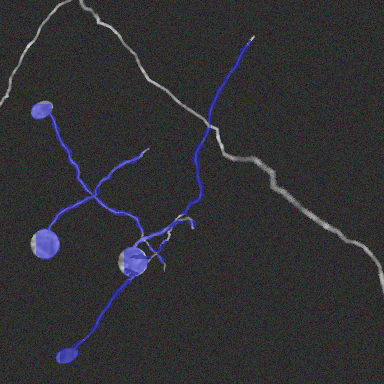

In [7]:
# setting variables in memory and displaying images
result = results[0]
img_orig = result.orig_img
img_labeled = result.plot(labels=False, boxes=False, masks=True)

img_orig_pil = Image.fromarray(img_orig)
img_labeled_pil = Image.fromarray(img_labeled)
# img_orig_pil.show()

polygons = result.masks.xy
draw_orig = ImageDraw.Draw(img_orig_pil)
draw_polygons(draw_orig, polygons)

img_labeled_pil

<h1>Trying to recreate .plot function</h1>

[(56, 56, 255), (56, 56, 255), (56, 56, 255), (56, 56, 255), (56, 56, 255), (56, 56, 255)]
<class 'numpy.ndarray'>


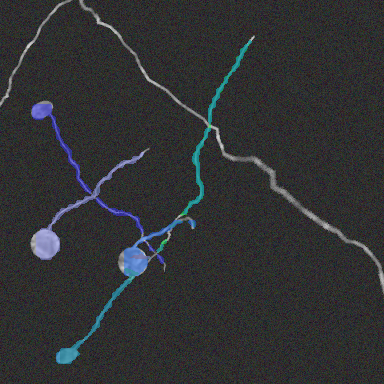

In [8]:
from ultralytics.data.augment import LetterBox
from ultralytics.utils.plotting import Annotator, colors, save_one_box
import torch
from copy import deepcopy 

img = None
line_width=None
font_size=None
font="Arial.ttf"
pil=False
boxes = False
labels = False
probs = True
im_gpu = None

if img is None and isinstance(result.orig_img, torch.Tensor):
    img = (result.orig_img[0].detach().permute(1, 2, 0).contiguous() * 255).to(torch.uint8).cpu().numpy()

names = result.names
is_obb = result.obb is not None
pred_boxes, show_boxes = result.obb if is_obb else result.boxes, boxes
pred_masks, show_masks = result.masks, True
pred_probs, show_probs = result.probs, probs

annotator = Annotator(
    deepcopy(result.orig_img if img is None else img),
    line_width,
    font_size,
    font,
    pil or (pred_probs is not None and show_probs),  # Classify tasks default to pil=True
    example=names,
)

if pred_masks and show_masks:
    if im_gpu is None:
        img = LetterBox(pred_masks.shape[1:])(image=annotator.result())
        im_gpu = (
            torch.as_tensor(img, dtype=torch.float16, device=pred_masks.data.device)
            .permute(2, 0, 1)
            .flip(0)
            .contiguous()
            / 255
        )
idx = pred_boxes.cls if pred_boxes else range(len(pred_masks))
print([colors(x, True) for x in idx])
# annotator.masks(pred_masks.data, colors=[colors(x, True) for x in idx], im_gpu=im_gpu)
annotator.masks(pred_masks.data, colors=[colors(x, True) for x in range(len(pred_masks.data))], im_gpu=im_gpu)

print(type(annotator.result()))
Image.fromarray(annotator.result())

In [15]:
def yolo_plot_dif_colors(result, img = None, line_width=None, font_size=None, font="Arial.ttf", pil=False, boxes = False, labels = False, probs = True, im_gpu = None):
    if img is None and isinstance(result.orig_img, torch.Tensor):
        img = (result.orig_img[0].detach().permute(1, 2, 0).contiguous() * 255).to(torch.uint8).cpu().numpy()

    names = result.names
    is_obb = result.obb is not None
    pred_boxes, show_boxes = result.obb if is_obb else result.boxes, boxes
    pred_masks, show_masks = result.masks, True
    pred_probs, show_probs = result.probs, probs

    annotator = Annotator(
        deepcopy(result.orig_img if img is None else img),
        line_width,
        font_size,
        font,
        pil or (pred_probs is not None and show_probs),  # Classify tasks default to pil=True
        example=names,
    )

    if pred_masks and show_masks:
        if im_gpu is None:
            img = LetterBox(pred_masks.shape[1:])(image=annotator.result())
            im_gpu = (
                torch.as_tensor(img, dtype=torch.float16, device=pred_masks.data.device)
                .permute(2, 0, 1)
                .flip(0)
                .contiguous()
                / 255
            )
    idx = pred_boxes.cls if pred_boxes else range(len(pred_masks))
    # print([colors(x, True) for x in idx])
    # annotator.masks(pred_masks.data, colors=[colors(x, True) for x in idx], im_gpu=im_gpu)
    annotator.masks(pred_masks.data, colors=[colors(x, True) for x in range(len(pred_masks.data))], im_gpu=im_gpu)

    # print(type(annotator.result()))
    return Image.fromarray(annotator.result())

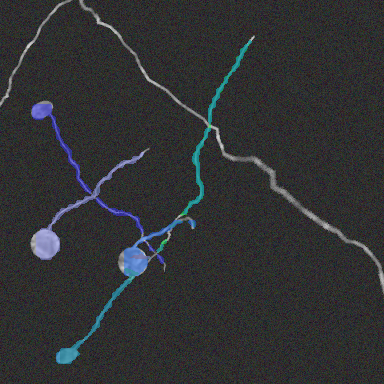

In [16]:
yolo_plot_dif_colors(result=result)

In [ ]:
i = Image.fromarray(annotator.result())
i

<h1>trying to recreate Annotator.masks() function</h1>

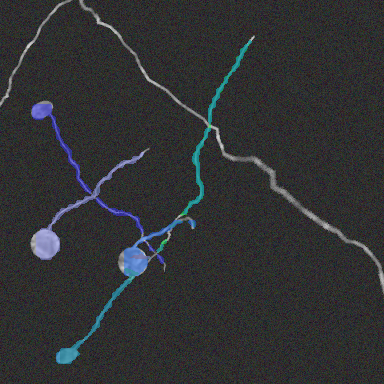

In [9]:
# from ultralytics.data.augment import LetterBox
# im_gpu = None

# if im_gpu is None:
#     img = LetterBox(pred_masks.shape[1:])(image=annotator.result())
#     im_gpu = (
#         torch.as_tensor(img, dtype=torch.float16, device=pred_masks.data.device)
#         .permute(2, 0, 1)
#         .flip(0)
#         .contiguous()
#         / 255
#     )
    

from ultralytics.utils import LOGGER, TryExcept, ops, plt_settings, threaded
from ultralytics.utils.plotting import Annotator, colors, save_one_box
alpha = 0.5
retina_masks = False
some_colors=[colors(x, True) for x in range(len(pred_masks.data))]


list_colors = torch.tensor(some_colors, device=pred_masks.data.device, dtype=torch.float32) / 255.0  # shape(n,3)
tensor_colors = list_colors[:, None, None]  # shape(n,1,1,3)
masks = pred_masks.data.unsqueeze(3)  # shape(n,h,w,1)
masks_color = masks * (tensor_colors * alpha)  # shape(n,h,w,3)

inv_alpha_masks = (1 - masks * alpha).cumprod(0)  # shape(n,h,w,1)
mcs = masks_color.max(dim=0).values  # shape(n,h,w,3)

im_gpu = im_gpu.flip(dims=[0])  # flip channel
im_gpu = im_gpu.permute(1, 2, 0).contiguous()  # shape(h,w,3)
im_gpu = im_gpu * inv_alpha_masks[-1] + mcs
im_mask = im_gpu * 255
im_mask_np = im_mask.byte().cpu().numpy()
annotator.im[:] = im_mask_np if retina_masks else ops.scale_image(im_mask_np, annotator.im.shape)

Image.fromarray(annotator.result())

In [ ]:
print(colors)

In [ ]:
print(pred_masks.data.unsqueeze(3).shape)

In [ ]:
print(pred_masks.data.shape)

In [ ]:
len(pred_masks.data)